<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S15/Experiment-Suite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check GPU instance

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8deaf73d-f00f-509d-4279-4abcf133efb7)


# Preparation for the experiment

In [2]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load required libraries

In [3]:
import sys

%rm -rf /content/eva
!git clone https://github.com/raguram/eva.git

sys.path.append("/content/eva/cnn-lib/src/cnnlib")
sys.path.append("/content/eva/cnn-lib/src/")
print("Added required libraries to system path")

Cloning into 'eva'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 858 (delta 87), reused 99 (delta 40), pack-reused 691
Receiving objects: 100% (858/858), 32.59 MiB | 8.07 MiB/s, done.
Resolving deltas: 100% (401/401), done.
Added required libraries to system path


In [4]:
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 9.0MB/s 
     |████████████████████████████████| 634kB 18.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=ee9ce8223b11c2bcc477c3ea783345230030f62fa7db854ebdeca6e586af7530
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=2b2e9c054c7a1cd42f508b4731f6a9a196e284df8c4884b253f3867b8e2d4a2a
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
from DataUtility import Alb
from albumentations import *
from albumentations.pytorch import ToTensor
from cnnlib import Utility
from torch.nn import functional as F
from cnnlib.DataUtility import Alb
import numpy as np
from cnnlib import DataUtility
import torch.optim as optim
from cnnlib.datasets.DepthDataset import DepthDataset
from cnnlib.models.ResUNet import ResUNet_Dual as ResUNet
from cnnlib.image_seg.ModelBuilder import *
import torch
from torchsummary import summary
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from DataUtility import shape
from cnnlib.DataUtility import Data
from cnnlib.image_seg.ModelBuilder import ModelBuilder
from image_seg.PredictionPersister import ZipPredictionPersister
from image_seg.Loss import Loss_fn
from torch.nn import BCEWithLogitsLoss

### Download and unzip the Tiny data set

In [6]:
!rm -rf /content/data
import Utility 
Utility.unzip("/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/tiny_data.zip", "/content/data")

uncompressed_size 371.686523


### Model Summary

In [10]:
model = ResUNet(6, 1).to(Utility.getDevice())
summary(model, (6, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             192
       BatchNorm2d-2           [-1, 32, 96, 96]              64
            Conv2d-3           [-1, 32, 96, 96]           1,760
       BatchNorm2d-4           [-1, 32, 96, 96]              64
              ReLU-5           [-1, 32, 96, 96]               0
            Conv2d-6           [-1, 32, 96, 96]           9,248
       BatchNorm2d-7           [-1, 32, 96, 96]              64
              ReLU-8           [-1, 32, 96, 96]               0
        DoubleConv-9           [-1, 32, 96, 96]               0
             ReLU-10           [-1, 32, 96, 96]               0
        MaxPool2d-11           [-1, 32, 48, 48]               0
         ResBlock-12  [[-1, 32, 48, 48], [-1, 32, 96, 96]]               0
           Conv2d-13           [-1, 64, 48, 48]           2,048
      BatchNorm2d-14        

### Transformations

In [0]:
bg_mean = (0.4491, 0.4220, 0.3982)
bg_std = (0.0056, 0.0045, 0.0048)

fg_bg_mean = (0.4393, 0.4124, 0.3921)
fg_bg_std = (0.0041, 0.0036, 0.0042)

bg_trans = Alb(Compose([HorizontalFlip(p=0.5),
Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=np.array([*bg_mean])*255.0, p=0.75),
#Normalize(bg_mean, bg_std),
ToTensor(),
]))

fg_bg_trans = Alb(Compose([HorizontalFlip(p=0.5),
Cutout(num_holes=1, max_h_size=16, max_w_size=16, fill_value=np.array([*fg_bg_mean])*255.0, p=0.75),
#Normalize(bg_mean, bg_std),
ToTensor(),
]))

target_trans = Alb(Compose([ToTensor()]))

### Create data loader

Total number of images in the dataset: 20000
Total number of images in the train dataset: 14000
Shape of a train data batch: torch.Size([128, 3, 112, 112])
Total number of images in the test dataset: 6000
Shape of a test data batch: torch.Size([128, 3, 112, 112])


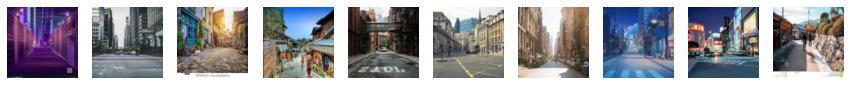

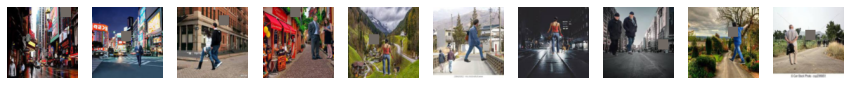

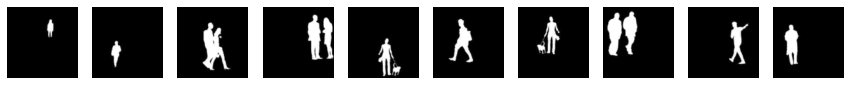

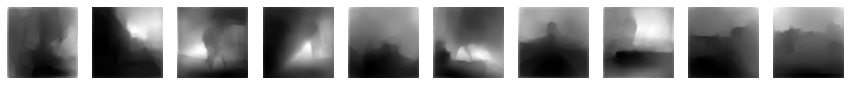

In [17]:
import math 
from DataUtility import Data

def create_loader():

  dataset = DepthDataset("/content/data", bg_transform=bg_trans, fg_bg_transform=fg_bg_trans, 
                         fg_bg_mask_transform=target_trans, fg_bg_depth_transform=target_trans, reshape=(112, 112))
  print(f"Total number of images in the dataset: {len(dataset)}") 

  num_train = math.ceil(len(dataset) * 0.70)
  train_dataset = torch.utils.data.Subset(dataset, range(0, num_train))
  test_dataset = torch.utils.data.Subset(dataset, range(num_train, len(dataset)))

  train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4)
  test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=128, num_workers=4)

  data = iter(train_loader).next()
  print(f"Total number of images in the train dataset: {len(train_dataset)}") 
  print(f"Shape of a train data batch: {data['fg_bg'].shape}")

  dataset.show_images(10)

  data = iter(test_loader).next()
  print(f"Total number of images in the test dataset: {len(test_dataset)}") 
  print(f"Shape of a test data batch: {data['fg_bg'].shape}")

  return Data(train_loader, test_loader)

data = create_loader()


# Experiment-1 Train only for Mask

Train the network only for the predicting mask. 

- Loss: BCEWithLogistisLoss 
- Optimizer: SGD
- LR: 0.5
- Momentum: 0.9
- Epochs: 20



In [0]:
from torch.optim.lr_scheduler import OneCycleLR

data_folder="/content/data/"
output_zip="/content/data_pred_exp1.zip"
output_folder="/content/data_pred_exp1/"
model_output_file="/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp1.pt"
epochs=20
model = ResUNet(6, 1).to(Utility.getDevice())

loss_fn = Loss_fn(mask_loss=BCEWithLogitsLoss(), depth_loss=None)

LR = 0.5
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=epochs, steps_per_epoch=len(data.train), 
                       pct_start=5/epochs, anneal_strategy='linear', div_factor=25.0, final_div_factor=1000)

persister = ZipPredictionPersister(zip_file_name=output_zip, percent=0.1)

### Build model

In [29]:
Utility.cleanup()
builder = ModelBuilder(model=model, data=data, loss_fn=loss_fn,
                       optimizer=optimizer, scheduler=scheduler, test_pred_persister=persister, model_path=model_output_file, checkpoint=5)

result = builder.fit(epochs)



Epoch: 1



Train Loss: 0.001960294096597603, Learning Rate: 0.02
Predicting on test set.



Test Loss: 0.0017911412939429284
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp1.pt


Epoch: 2



Train Loss: 0.001454605814601694, Learning Rate: 0.11617486338797814


Epoch: 3



Train Loss: 0.0010636001878551074, Learning Rate: 0.21234972677595626


Epoch: 4



Train Loss: 0.0007853766748947757, Learning Rate: 0.3085245901639344


Epoch: 5



Train Loss: 0.0006677572210984571, Learning Rate: 0.40469945355191256


Epoch: 6



Train Loss: 0.0005878820839737142, Learning Rate: 0.49969698181818184
Predicting on test set.



Test Loss: 0.0006224720651904742
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp1.pt


Epoch: 7



Train Loss: 0.0005434453843959741, Learning Rate: 0.4663649818181818


Epoch: 8



Train Loss: 0.0004983720329723187, Learning Rate: 0.43303298181818184


Epoch: 9



Train Loss: 0.00047403040741171153, Learning Rate: 0.3997009818181818


Epoch: 10



Train Loss: 0.00045244803306247506, Learning Rate: 0.3663689818181818


Epoch: 11



Train Loss: 0.0004324477267052446, Learning Rate: 0.33303698181818187
Predicting on test set.



Test Loss: 0.00045155567737917106
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp1.pt


Epoch: 12



Train Loss: 0.00041769666810120853, Learning Rate: 0.29970498181818184


Epoch: 13



Train Loss: 0.00041350707172283104, Learning Rate: 0.2663729818181818


Epoch: 14



Train Loss: 0.00039907544824693884, Learning Rate: 0.23304098181818184


Epoch: 15



Train Loss: 0.0003859361737434353, Learning Rate: 0.19970898181818186


Epoch: 16



Train Loss: 0.00037562480914805614, Learning Rate: 0.16637698181818183
Predicting on test set.



Test Loss: 0.00041400086817642055
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp1.pt


Epoch: 17



Train Loss: 0.00036802484494234835, Learning Rate: 0.13304498181818186


Epoch: 18



Train Loss: 0.00035988810073052136, Learning Rate: 0.09971298181818183


Epoch: 19



Train Loss: 0.00035473583053265297, Learning Rate: 0.0663809818181818


Epoch: 20



Train Loss: 0.00034819524149809565, Learning Rate: 0.03304898181818183
Predicting on test set.



Test Loss: 0.0003944854655613502
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp1.pt


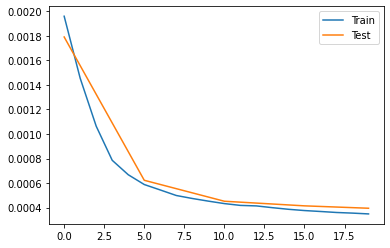

In [30]:
import MetricsUtility
from matplotlib import pyplot as plt

MetricsUtility.plot_x_y(result.train_losses, "Train")
MetricsUtility.plot_x_y(result.test_losses, "Test")
plt.show()

### View prediction result

In [31]:
!rm -rf /content/data_pred_exp1/
Utility.unzip(output_zip, output_folder)

uncompressed_size 43.810317


FG_BG
FG_BG
FG_BG Predicted


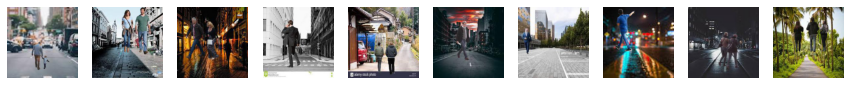

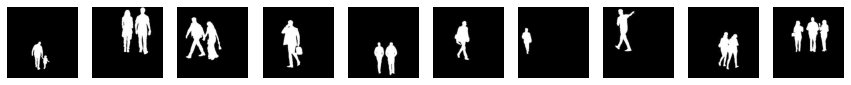

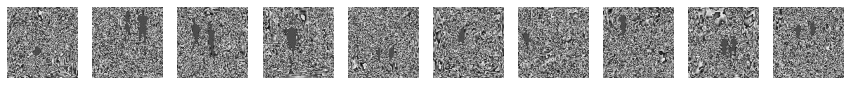

In [32]:
import ImageUtils
from os import listdir
from os.path import join
from PIL import Image

fg_bg_folder = f"{data_folder}fg_bg"
fg_bg_mask_folder = f"{data_folder}fg_bg_mask"
prediction_folder = f"{output_folder}/epoch-{epochs-1}/fg_bg_mask"

file_names = listdir(prediction_folder)[10:20]
print("FG_BG")
ImageUtils.show_images([Image.open(join(fg_bg_folder, f)) for f in file_names])
print("FG_BG")
ImageUtils.show_images([Image.open(join(fg_bg_mask_folder, f)) for f in file_names])
print("FG_BG Predicted")
ImageUtils.show_images([Image.open(join(prediction_folder, f)) for f in file_names])

# Experiment- 2 Train only for Mask - F1 Loss

Train the network only for the predicting mask. 

- Loss: L1 Loss 
- Optimizer: SGD
- LR: 0.5
- Momentum: 0.9
- Epochs: 20



In [0]:
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn

data_folder="/content/data/"
output_zip="/content/data_pred_exp2.zip"
output_folder="/content/data_pred_exp2/"
model_output_file="/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp2.pt"
epochs=20
model = ResUNet(6, 1).to(Utility.getDevice())

loss_fn = Loss_fn(mask_loss=nn.L1Loss(), depth_loss=None)

LR = 0.5
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=epochs, steps_per_epoch=len(data.train), 
                       pct_start=5/epochs, anneal_strategy='linear', div_factor=25.0, final_div_factor=1000)

persister = ZipPredictionPersister(zip_file_name=output_zip, percent=0.1)

### Build model

In [41]:
Utility.cleanup()
builder = ModelBuilder(model=model, data=data, loss_fn=loss_fn,
                       optimizer=optimizer, scheduler=scheduler, test_pred_persister=persister, model_path=model_output_file, checkpoint=5)

result = builder.fit(epochs)



Epoch: 1



Train Loss: 0.0011424209198781423, Learning Rate: 0.02
Predicting on test set.



Test Loss: 0.0033685005654891334
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp2.pt


Epoch: 2



Train Loss: 0.0021744796905134407, Learning Rate: 0.11617486338797814


Epoch: 3



Train Loss: 0.0019526759327522347, Learning Rate: 0.21234972677595626


Epoch: 4



Train Loss: 0.0024458067305386066, Learning Rate: 0.3085245901639344


Epoch: 5



Train Loss: 0.0036136447111410753, Learning Rate: 0.40469945355191256


Epoch: 6



Train Loss: 0.003988253350236586, Learning Rate: 0.49969698181818184
Predicting on test set.



Test Loss: 0.003481027806798617
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp2.pt


Epoch: 7



Train Loss: 0.004005598081009728, Learning Rate: 0.4663649818181818


Epoch: 8



Train Loss: 0.00379307107893484, Learning Rate: 0.43303298181818184


Epoch: 9



Train Loss: 0.003803733132247414, Learning Rate: 0.3997009818181818


Epoch: 10



Train Loss: 0.003804265803524426, Learning Rate: 0.3663689818181818


Epoch: 11



Train Loss: 0.0035654829660696644, Learning Rate: 0.33303698181818187
Predicting on test set.



Test Loss: 0.0017651523848374684
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp2.pt


Epoch: 12



Train Loss: 0.0028237514549068043, Learning Rate: 0.29970498181818184


Epoch: 13



Train Loss: 0.0031900498270988464, Learning Rate: 0.2663729818181818


Epoch: 14



Train Loss: 0.002178600742348603, Learning Rate: 0.23304098181818184


Epoch: 15



Train Loss: 0.002385348263063601, Learning Rate: 0.19970898181818186


Epoch: 16



Train Loss: 0.0026209490400339874, Learning Rate: 0.16637698181818183
Predicting on test set.



Test Loss: 0.0017765665998061499
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp2.pt


Epoch: 17



Train Loss: 0.001880516601992505, Learning Rate: 0.13304498181818186


Epoch: 18



Train Loss: 0.0015372201417173659, Learning Rate: 0.09971298181818183


Epoch: 19



Train Loss: 0.0012367725963039057, Learning Rate: 0.0663809818181818


Epoch: 20



Train Loss: 0.0007321967503854206, Learning Rate: 0.03304898181818183
Predicting on test set.



Test Loss: 0.000518614704410235
Saved the model to path:/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp2.pt


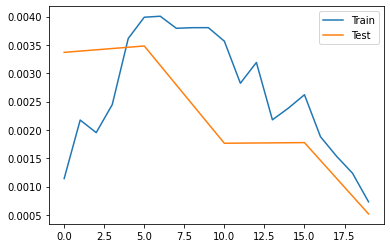

In [42]:
import MetricsUtility
from matplotlib import pyplot as plt

MetricsUtility.plot_x_y(result.train_losses, "Train")
MetricsUtility.plot_x_y(result.test_losses, "Test")
plt.show()

### View prediction result

In [43]:
!rm -rf /content/data_pred_exp2/
Utility.unzip(output_zip, output_folder)

uncompressed_size 20.906347


FG_BG
FG_BG
FG_BG Predicted


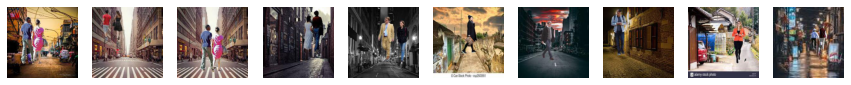

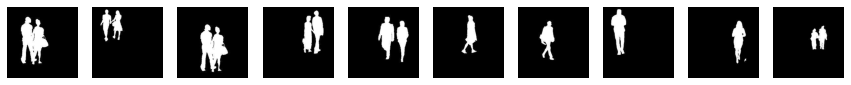

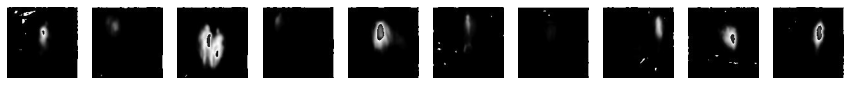

In [44]:
import ImageUtils
from os import listdir
from os.path import join
from PIL import Image

fg_bg_folder = f"{data_folder}fg_bg"
fg_bg_mask_folder = f"{data_folder}fg_bg_mask"
prediction_folder = f"{output_folder}/epoch-{epochs-1}/fg_bg_mask"

file_names = listdir(prediction_folder)[10:20]
print("FG_BG")
ImageUtils.show_images([Image.open(join(fg_bg_folder, f)) for f in file_names])
print("FG_BG")
ImageUtils.show_images([Image.open(join(fg_bg_mask_folder, f)) for f in file_names])
print("FG_BG Predicted")
ImageUtils.show_images([Image.open(join(prediction_folder, f)) for f in file_names])

# Experiment - 3 Train only for Depth - RootMeanSquaredErrorLoss

Train the network only for the predicting depth. 

- Loss: Root Mean Squared error Loss 
- Optimizer: SGD
- LR: 0.5
- Momentum: 0.9
- Epochs: 20


In [0]:
from cnnlib.image_seg.Loss import RootMeanSquaredErrorLoss

data_folder="/content/data/"
output_zip="/content/data_pred_exp2.zip"
output_folder="/content/data_pred_exp2/"
model_output_file="/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data_pred_exp2.pt"
epochs=20
model = ResUNet(6, 1).to(Utility.getDevice())
loss_fn = Loss_fn(depth_loss=RootMeanSquaredErrorLoss(), mask_loss=None)

LR = 0.5
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=epochs, steps_per_epoch=len(data.train), 
                       pct_start=3/epochs, anneal_strategy='linear', div_factor=100.0, final_div_factor=1000)


### Build model

In [0]:
builder = ModelBuilder(model=model, data=data, loss_fn=loss_fn,
                       optimizer=optimizer, scheduler=scheduler, test_pred_persister=persister, model_path=model_output_file, checkpoint=5)

result = builder.fit(epochs)

In [0]:
import MetricsUtility
from matplotlib import pyplot as plt

MetricsUtility.plot_x_y(result.train_losses, "Train")
MetricsUtility.plot_x_y(result.test_losses, "Test")
plt.show()

### View prediction result

In [0]:
!rm -rf data_pred_exp2
Utility.unzip("/content/data_pred_exp1.zip", output_folder)

In [0]:
import ImageUtils
from os import listdir
from os.path import join
from PIL import Image

fg_bg_folder = f"{data_folder}fg_bg"
fg_bg_depth_folder = f"{data_folder}fg_bg_depth"
prediction_folder = f"{output_folder}/epoch-{epochs-1}/fg_bg_depth"

file_names = listdir(prediction_folder)[:10]
ImageUtils.show_images([Image.open(join(fg_bg_folder, f)) for f in file_names])
ImageUtils.show_images([Image.open(join(fg_bg_depth_folder, f)) for f in file_names])
ImageUtils.show_images([Image.open(join(prediction_folder, f)) for f in file_names])